In [2]:
import os
import cv2
import numpy as np
import librosa
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM, MaxPooling2D, Dropout, TimeDistributed, Reshape
from tensorflow.keras.utils import to_categorical

2024-05-23 14:56:17.182788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 14:56:17.182916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 14:56:17.303457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading The Data In wave form**

In [3]:
def load_audio_file(file_path, duration=2.0, sr=22050):
    audio_data, sr = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    return audio_data, sr

In [4]:
def load_data_from_folders(real_folder, fake_folder, sr=22050):
    real_data = []
    fake_data = []
    labels = []

    # Load real data
    for file_name in os.listdir(real_folder):
        if file_name.endswith('.wav'):
            audio_data, _ = load_audio_file(os.path.join(real_folder, file_name), sr=sr)
            real_data.append(audio_data)
            labels.append(1)  # Label 1 for real voices

    # Load fake data
    for file_name in os.listdir(fake_folder):
        if file_name.endswith('.wav'):
            audio_data, _ = load_audio_file(os.path.join(fake_folder, file_name), sr=sr)
            fake_data.append(audio_data)
            labels.append(0)  # Label 0 for fake voices

    return real_data, fake_data, labels


In [5]:
real_data, fake_data, labels = load_data_from_folders('/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real', '/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake')

**Visualizing the data in  wave form**

In [6]:
def visualize_waveform(audio_data, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()


In [7]:
def visualize_audio_from_folders(real_folder, fake_folder):
    # Load and visualize real data
    real_files = os.listdir(real_folder)[:2]
    for file_name in real_files:
        if file_name.endswith('.wav'):
            audio_data, sr = load_audio_file(os.path.join(real_folder, file_name))
            visualize_waveform(audio_data, sr, title=f'Real: {file_name}')
    
    # Load and visualize fake data
    fake_files = os.listdir(fake_folder)[:2]
    for file_name in fake_files:
        if file_name.endswith('.wav'):
            audio_data, sr = load_audio_file(os.path.join(fake_folder, file_name))
            visualize_waveform(audio_data, sr, title=f'Fake: {file_name}')


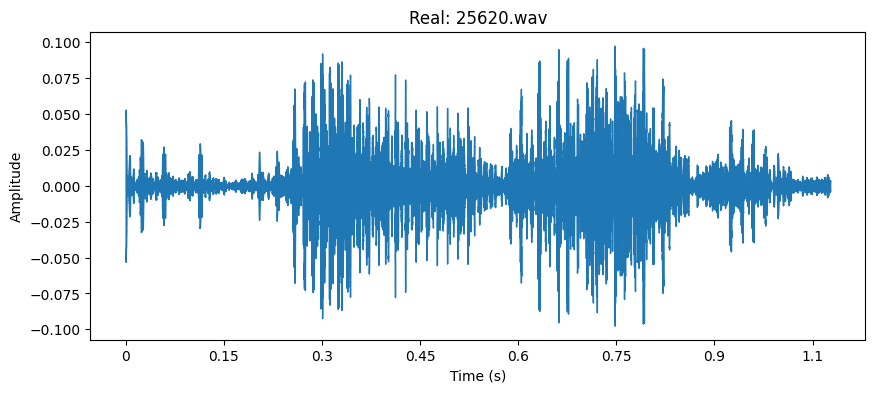

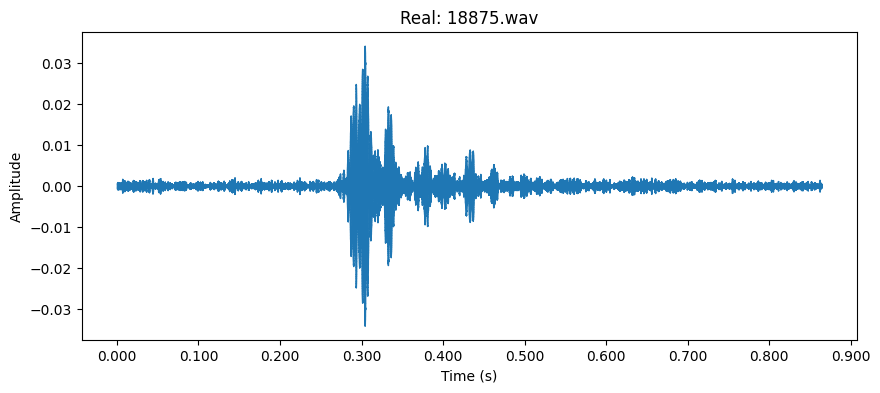

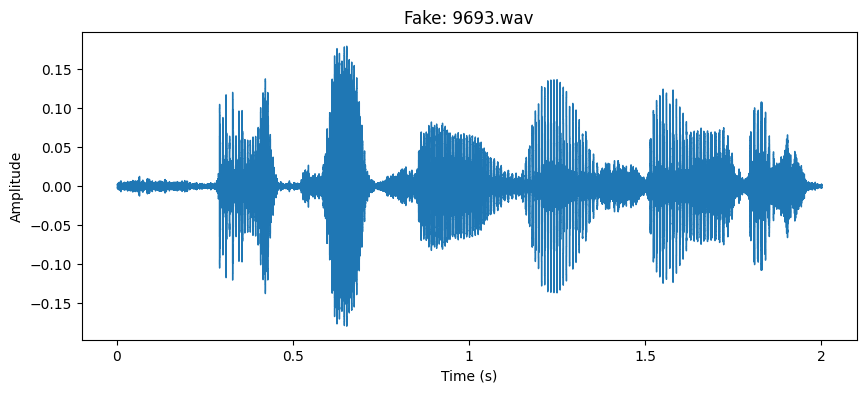

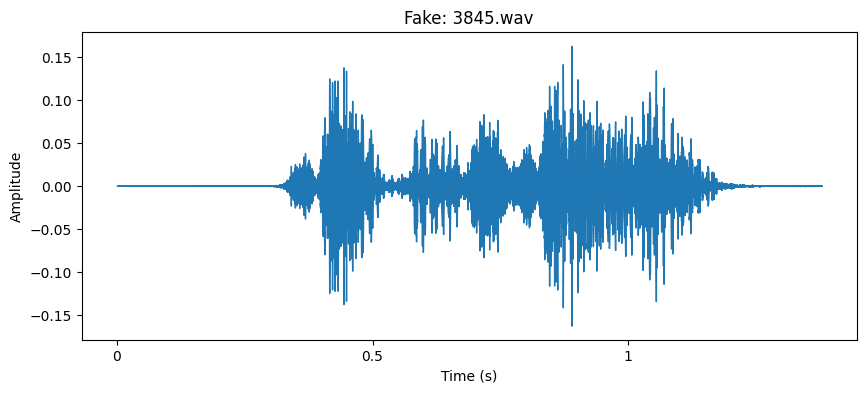

In [8]:

visualize_audio_from_folders('/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real', '/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/fake')


# **Extracting Spectrograms**

In [9]:
def extract_spectrogram(audio_data, sr):
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    return spectrogram

In [10]:
def extract_spectrograms(data, sr):
    spectrograms = []
    for audio in data:
        spectrogram = extract_spectrogram(audio, sr)
        spectrograms.append(spectrogram)
    return spectrograms

In [11]:
sr = 22050
real_spectrograms = extract_spectrograms(real_data, sr)
fake_spectrograms = extract_spectrograms(fake_data, sr)

**Visualization of Spectrogams**

In [12]:
def visualize_spectrogram(spectrogram, sr):
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

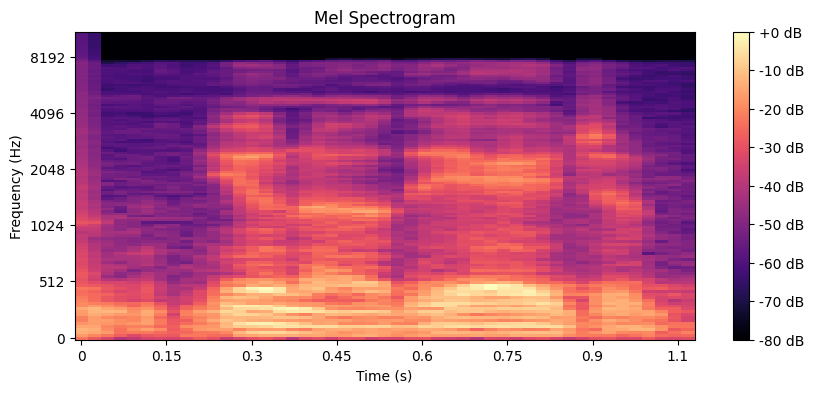

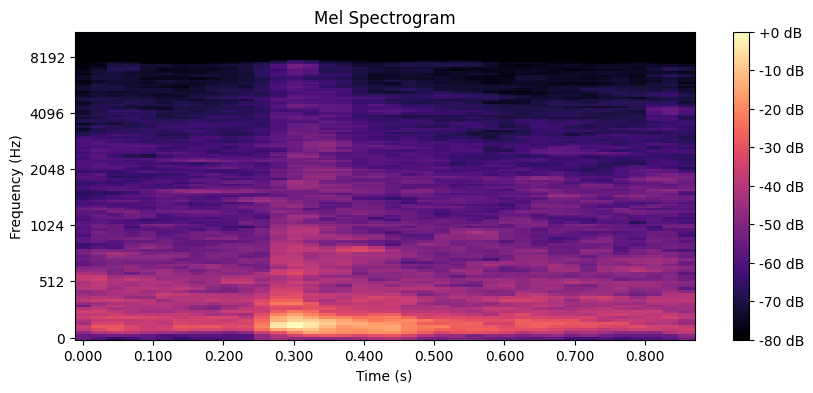

In [13]:
# Visualize first two real spectrograms
for spectrogram in real_spectrograms[:2]:
    visualize_spectrogram(spectrogram, sr)

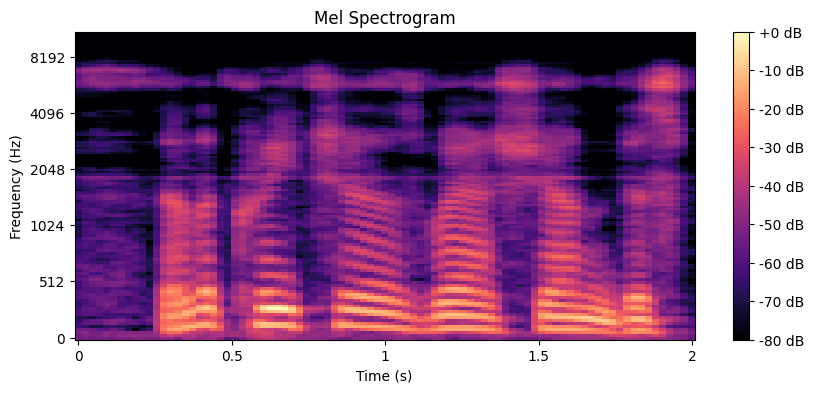

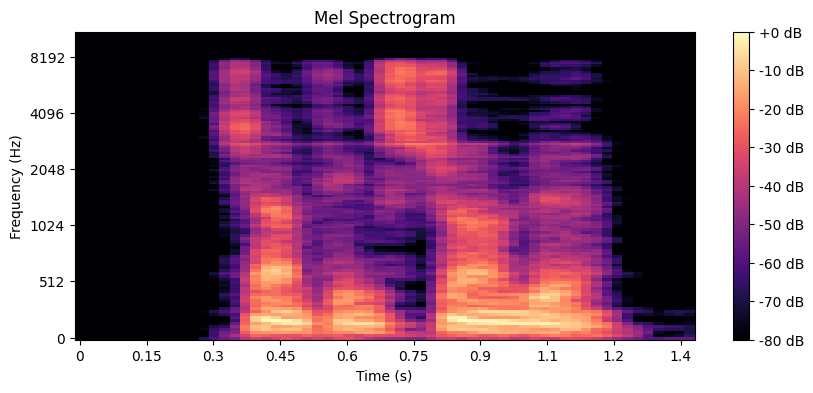

In [14]:
# Visualize first two fake spectrograms
for spectrogram in fake_spectrograms[:2]:
    visualize_spectrogram(spectrogram, sr)

# **Extracting Features**

In [15]:
def extract_features(spectrogram):
    mean = np.mean(spectrogram)
    std_dev = np.std(spectrogram)
    skewness = skew(spectrogram, axis=None)
    kurtosis_val = kurtosis(spectrogram, axis=None)
    return [mean, std_dev, skewness, kurtosis_val]

In [16]:
# Extract features from spectrograms
real_features = [extract_features(spectrogram) for spectrogram in real_spectrograms]
fake_features = [extract_features(spectrogram) for spectrogram in fake_spectrograms]

In [17]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [18]:
real_features

[[0.0849998, 0.44601765, 10.108941509430807, 133.9614777710324],
 [0.002976094, 0.060890146, 34.25566302437936, 1343.3511466535795],
 [0.41708258, 4.046952, 21.43417483812815, 622.82494242991],
 [0.28960577, 2.9321811, 18.359657757216215, 412.28406713152606],
 [0.40187126, 3.5679352, 15.99764535210767, 312.6029471417422],
 [0.2719216, 2.1744041, 23.592432040457506, 748.8514056677385],
 [0.4226054, 6.361471, 20.47970956707093, 476.90122552592385],
 [0.78291935, 6.907606, 24.655134027752425, 913.3770451000804],
 [0.6061951, 3.9599662, 12.11888908059708, 193.72684210945056],
 [0.13668697, 1.3450683, 29.350762317757468, 1161.1000356620827],
 [0.1433016, 1.2934843, 17.912735885440384, 397.99598102015875],
 [0.56268185, 6.575987, 23.476135073698046, 700.2178048883501],
 [0.8845038, 7.6427402, 17.70348007747477, 422.0406530770972],
 [14.141558, 102.882996, 13.606901316718412, 232.71612548048674],
 [0.23634385, 1.693519, 15.343769677340033, 349.38644746831403],
 [1.1069965, 7.244538, 12.840564

In [19]:
X = np.concatenate((real_features, fake_features), axis=0)
y = np.array([1]*len(real_features) + [0]*len(fake_features))

In [20]:
X_resized = np.array([cv2.resize(x, (128, 128)) for x in X])

In [21]:
X_resized = np.expand_dims(X_resized, axis=-1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=38, stratify=y)

# **Building a Model Architecture**

In [31]:
# Build the hybrid CNN-RNN model
model = Sequential()

# Add CNN layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Prepare for RNN
model.add(Reshape((32, 2048)))  # Adjust this shape according to your architecture

# Add RNN layers
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))

# Add dense layers for classification
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 32, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 64)         │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,993 (2.28 MB)

 Trainable params: 596,993 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


2024-05-23 15:17:09.462458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_21_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


636/636 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6148 - loss: 0.6413 - val_accuracy: 0.6421 - val_loss: 0.6327
Epoch 2/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6240 - loss: 0.6211 - val_accuracy: 0.6423 - val_loss: 0.6200
Epoch 3/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6220 - loss: 0.6233 - val_accuracy: 0.6423 - val_loss: 0.6215
Epoch 4/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6247 - loss: 0.6216 - val_accuracy: 0.6088 - val_loss: 0.6251
Epoch 5/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6347 - loss: 0.6132 - val_accuracy: 0.6100 - val_loss: 0.6210
Epoch 6/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6305 - loss: 0.6197 - val_accuracy: 0.6431 - val_loss: 0.6203
Epoch 7/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6443 - loss: 0.6080 - val_accuracy: 0.6409 - val_loss: 0.6182
Epoch 8/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6430 - loss: 0.6124 - val_

In [33]:
loss, accuracy = model.evaluate(X_test, y_test)

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6334 - loss: 0.6204


In [34]:
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.64


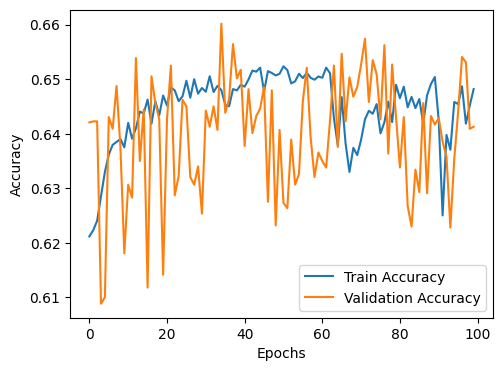

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

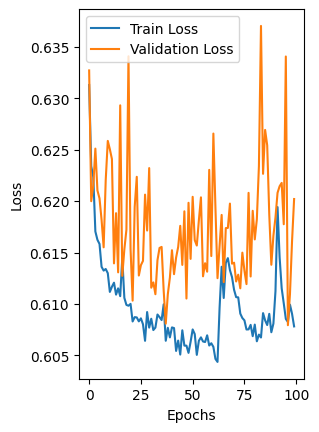

In [36]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Please do tell me how can I imporve my model. I have used Hybrid approach because it helped with other audio classification task. Tell me better approach to do it. Thankyou in advance.**